In [165]:
using Gen, Statistics, StatsPlots, BenchmarkTools, TimerOutputs, Memoize, POMDPs, POMDPModels, POMDPModelTools, LinearAlgebra

## Introduction

The previous chapter introduced agent models for solving simple, one-shot decision problems. The next few sections introduce *sequential* problems, where an agent's choice of action *now* depends on the actions they will choose in the future. As in game theory, the decision maker must coordinate with another rational agent. But in sequential decision problems, that rational agent is their future self.

As a simple illustration of a sequential decision problem, suppose that an agent, Bob, is looking for a place to eat. Bob gets out of work in a particular location (indicated below by the blue circle). He knows the streets and the restaurants nearby. His decision problem is to take a sequence of actions such that (a) he eats at a restaurant he likes and (b) he does not spend too much time walking. Here is a visualization of the street layout. The labels refer to different types of restaurants: a chain selling Donuts, a Vegetarian Salad Bar and a Noodle Shop.

~~~~javascript
var ___ = ' '; 
var DN = { name: 'Donut N' };
var DS = { name: 'Donut S' };
var V = { name: 'Veg' };
var N = { name: 'Noodle' };

var grid = [
  ['#', '#', '#', '#',  V , '#'],
  ['#', '#', '#', ___, ___, ___],
  ['#', '#', DN , ___, '#', ___],
  ['#', '#', '#', ___, '#', ___],
  ['#', '#', '#', ___, ___, ___],
  ['#', '#', '#', ___, '#',  N ],
  [___, ___, ___, ___, '#', '#'],
  [DS , '#', '#', ___, '#', '#']
];

var mdp = makeGridWorldMDP({ grid, start: [3, 1] });

viz.gridworld(mdp.world, { trajectory : [mdp.startState] });
~~~~

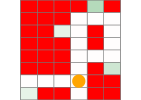

In [174]:
grid_world = [
    "#" "#" "#" "#" "V" "#" ;
    "#" "#" "#" "___" "___" "___";
    "#" "#" "DN" "___" "#" "___";
    "#" "#" "#" "___" "#" "___";
    "#" "#" "#" "___" "___" "___";
    "#" "#" "#" "___" "#" "N";
    "___" "___" "___" "___" "#" "#";
    "DS" "#" "#" "___" "#" "#";
]
grid_world_utilities = Dict(
  "DS" => 1, 
  "DN" => 1, 
  "V" => 3,
  "N" => 2, 
  "___"=> -0.1,
  "#" => -1000000
)
n_rows, n_cols = size(grid_world)
function grid_to_utilities_dict(grid_world)
    utilities_dict = Dict()
    for i=1:n_rows
        for j=1:n_cols
            utility = grid_world_utilities[grid_world[n_rows+1 - i,j]]
            utilities_dict[GWPos(j, i)] = utility
        end
    end
    return utilities_dict
end
grid_size = (6,8)
gw = SimpleGridWorld(size=grid_size,rewards=grid_to_utilities_dict(grid_world))
render(gw, (s=[4,2],))

<a id="mdp"></a>

## Markov Decision Processes: Definition

We represent Bob's decision problem as a Markov Decision Process (MDP) and, more specifically, as a discrete "Gridworld" environment. An MDP is a tuple $ \left\langle S,A(s),T(s,a),U(s,a) \right\rangle$, including the *states*, the *actions* in each state, the *transition function* that maps state-action pairs to successor states, and the *utility* or *reward* function. In our example, the states $S$ are Bob's locations on the grid. At each state, Bob selects an action $a \in \{ \text{up}, \text{down}, \text{left}, \text{right} \} $, which moves Bob around the grid (according to transition function $T$). In this example we assume that Bob's actions, as well as the transitions and utilities, are all deterministic. However, our approach generalizes to noisy actions, stochastic transitions and stochastic utilities.

As with the one-shot decisions of the previous chapter, the agent in an MDP will choose actions that *maximize expected utility*. This depends on the total utility of the *sequence* of states that the agent visits. Formally, let $EU_{s}[a]$ be the expected (total) utility of action $a$ in state $s$. The agent's choice is a softmax function of this expected utility:

$
C(a; s) \propto e^{\alpha EU_{s}[a]}
$

The expected utility depends on both immediate utility and, recursively, on future expected utility:

<a id="recursion">**Expected Utility Recursion**</a>:

$
EU_{s}[a] = U(s, a) + \mathbb{E}_{s', a'}(EU_{s'}[a'])
$

<br>
with the next state $s' \sim T(s,a)$ and $a' \sim C(s')$. The decision problem ends either when a *terminal* state is reached or when the time-horizon is reached. (In the next few chapters the time-horizon will always be finite). 

The intuition to keep in mind for solving MDPs is that the expected utility propagates backwards from future states to the current action. If a high utility state can be reached by a sequence of actions starting from action $a$, then action $a$ will have high expected utility -- *provided* that the sequence of actions is taken with high probability and there are no low utility steps along the way.

## Markov Decision Processes: Implementation

The recursive decision rule for MDP agents can be directly translated into WebPPL. The `act` function takes the agent's state as input, evaluates the expectation of actions in that state, and returns a softmax distribution over actions. The expected utility of actions is computed by a separate function `expectedUtility`. Since an action's expected utility depends on future actions, `expectedUtility` calls `act` in a mutual recursion, bottoming out when a terminal state is reached or when time runs out. 

We illustrate this "MDP agent" on a simple MDP:

### Integer Line MDP
- **States**: Points on the integer line (e.g -1, 0, 1, 2).

- **Actions/transitions**: Actions "left", "right" and "stay" move the agent deterministically along the line in either direction.

- **Utility**: The utility is $1$ for the state corresponding to the integer $3$ and is $0$ otherwise. 


Here is a WebPPL agent that starts at the origin (`state === 0`) and that takes a first step (to the right):

~~~~javascript
var transition = function(state, action) {
  return state + action;
};

var utility = function(state) {
  if (state === 3) {
    return 1;
  } else {
    return 0;
  }
};

var makeAgent = function() { 
  
  var act = function(state, timeLeft) {
    return Infer({ model() {
      var action = uniformDraw([-1, 0, 1]);
      var eu = expectedUtility(state, action, timeLeft);
      factor(100 * eu);
      return action;
    }});
  };

  var expectedUtility = function(state, action, timeLeft){
    var u = utility(state, action);
    var newTimeLeft = timeLeft - 1;
    if (newTimeLeft === 0){
      return u; 
    } else {
      return u + expectation(Infer({ model() {
        var nextState = transition(state, action); 
        var nextAction = sample(act(nextState, newTimeLeft));
        return expectedUtility(nextState, nextAction, newTimeLeft);
      }}));
    }
  };

  return { act };
}

var act = makeAgent().act;

var startState = 0;
var totalTime = 4;

// Agent's move '-1' means 'left', '0' means 'stay', '1' means 'right'
print("Agent's action: " + sample(act(startState, totalTime)));
~~~~

In [111]:
function transition(state,action)
    return state+action
end

function utility(state)
  if state == 3
    return 1
  else
    return 0
  end
end

function make_agent()
    @gen function act(state,time_left)
        action = @trace(uniform_discrete(-1,1),:action)
        eu = expected_utility(state,action,time_left)
        @trace(bernoulli(exp(100 * eu)),:factor)
    end
    function expected_utility(state,action,time_left)
        u = utility(state)
        new_time_left = time_left-1
        if new_time_left == 0
            return u
        else
            eus = []
            next_state = transition(state,action)
            trace, = generate(act, (next_state,new_time_left), choicemap((:factor,1)))
            push!(eus,expected_utility(next_state, trace[:action], new_time_left))
            return u + mean(eus)
        end
    end
    return (act,expected_utility)
end


make_agent (generic function with 1 method)

In [112]:
act, = make_agent()
start_state = 0
total_time = 9
amount_of_computation = 1000
trace, = generate(act,(start_state,total_time), choicemap((:factor,1)))
actions = []
for i = 1:amount_of_computation
    trace, = Gen.mh(trace, select(:action))
    push!(actions, trace[:action])
end
print("Agent actions: ")
println(trace[:action])

Agent actions: 1


This code computes the agent's initial action, given that the agent will get to take four actions in total. To simulate the agent's entire trajectory, we add a third function `simulate`, which updates and stores the world state in response to the agent's actions:

~~~~javascript
var transition = function(state, action) {
  return state + action;
};

var utility = function(state) {
  if (state === 3) {
    return 1;
  } else {
    return 0;
  }
};

var makeAgent = function() { 
  var act = function(state, timeLeft) {
    return Infer({ model() {
      var action = uniformDraw([-1, 0, 1]);
      var eu = expectedUtility(state, action, timeLeft);
      factor(100 * eu);
      return action;
    }});
  };

  var expectedUtility = function(state, action, timeLeft) {
    var u = utility(state, action);
    var newTimeLeft = timeLeft - 1;
    if (newTimeLeft === 0) {
      return u; 
    } else {
      return u + expectation(Infer({ model() {
        var nextState = transition(state, action); 
        var nextAction = sample(act(nextState, newTimeLeft));
        return expectedUtility(nextState, nextAction, newTimeLeft);
      }}));
    }
  };

  return { act };
}


var act = makeAgent().act;

var simulate = function(state, timeLeft){
  if (timeLeft === 0){
    return [];
  } else {
    var action = sample(act(state, timeLeft));
    var nextState = transition(state, action); 
    return [state].concat(simulate(nextState, timeLeft - 1))
  }
};

var startState = 0;
var totalTime = 4;
print("Agent's trajectory: " + simulate(startState, totalTime));
~~~~

In [97]:
function transition(state,action)
    return state+action
end

function utility(state)
  if state == 3
    return 1
  else
    return 0
  end
end

function make_agent()
    @gen function act(state,time_left)
        action = @trace(uniform_discrete(-1,1),:action)
        eu = expected_utility(state,action,time_left)
        @trace(bernoulli(exp(100 * eu)),:factor)
    end
    function expected_utility(state,action,time_left)
        u = utility(state)
        new_time_left = time_left-1
        if new_time_left == 0
            return u
        else
            eus = []
            next_state = transition(state,action)
            trace, = generate(act, (next_state,new_time_left), choicemap((:factor,1)))
            push!(eus,expected_utility(next_state, trace[:action], new_time_left))
            return u + mean(eus)
        end
    end
    return (act,expected_utility)
end

function simulate(start_state,total_time,steps_to_simulate)
    states = [start_state]
    act, = make_agent()
    amount_of_computation = 1000
    for i = 1:steps_to_simulate
        trace, = generate(act,(start_state,total_time), choicemap((:factor,1)))
        for i = 1:amount_of_computation
            trace, = Gen.mh(trace, select(:action))
        end
        next_state = transition(start_state,trace[:action])
        start_state = next_state
        total_time = total_time - 1
        push!(states,next_state)
    end
    return states
end


simulate (generic function with 1 method)

In [98]:
start_state = 0
total_time = 4;
print("Agent's trajectory: ")
println(simulate(start_state, total_time,total_time-1));

Agent's trajectory: [0, 1, 2, 3]


>**Exercise**: Change the world such that it is a loop, i.e. moving right from state `3` moves to state `0`, and moving left from state `0` moves to state `3`. How does this change the agent's sequence of actions?

>**Exercise**: Change the agent's action space such that the agent can also move two steps at a time. How does this change the agent's sequence of actions?

>**Exercise**: Change the agent's utility function such that the agent moves as far as possible to the right, given its available total time.

The `expectedUtility` and `simulate` functions are similar. The `expectedUtilty` function includes the agent's own (*subjective*) simulation of the future distribution on states. In the case of an MDP and optimal agent, the agent's simulation is identical to the world simulator. In later chapters, we describe agents whose subjective simulations differ from the world simulator. These agents either have inaccurate models of their own future choices or innacurate models of the world.

We already mentioned the mutual recursion between `act` and `expectedUtility`. What does this recursion look like if we unroll it? In this example we get a tree that expands until `timeLeft` reaches zero. The root is the starting state (`startState === 0`) and this branches into three successor states (`-1`, `0`, `1`). This leads to an exponential blow-up in the runtime of a single action (which depends on how long into the future the agent plans):

~~~~javascript
///fold: transition, utility, makeAgent, act, and simulate as above
var transition = function(state, action) {
  return state + action;
};

var utility = function(state) {
  if (state === 3) {
    return 1;
  } else {
    return 0;
  }
};

var makeAgent = function() { 

  var act = function(state, timeLeft) {
    return Infer({ model() {
      var action = uniformDraw([-1, 0, 1]);
      var eu = expectedUtility(state, action, timeLeft);
      factor(100 * eu);
      return action;
    }});
  };

  var expectedUtility = function(state, action, timeLeft) {
    var u = utility(state, action);
    var newTimeLeft = timeLeft - 1;
    if (newTimeLeft === 0) {
      return u; 
    } else {
      return u + expectation(Infer({ model() {
        var nextState = transition(state, action); 
        var nextAction = sample(act(nextState, newTimeLeft));
        return expectedUtility(nextState, nextAction, newTimeLeft);
      }}));
    }
  };

  return { act };
}


var act = makeAgent().act;

var simulate = function(state, timeLeft){
  if (timeLeft === 0){
    return [];
  } else {
    var action = sample(act(state, timeLeft));
    var nextState = transition(state, action); 
    return [state].concat(simulate(nextState, timeLeft - 1))
  }
};
///

var startState = 0;

var getRuntime = function(totalTime) {
  return timeit(function() {
    return act(startState, totalTime);
  }).runtimeInMilliseconds.toPrecision(4);
};

var numSteps = [3, 4, 5, 6, 7];
var runtimes = map(getRuntime, numSteps);

print('Runtime in ms for for a given number of steps: \n')
print(_.zipObject(numSteps, runtimes));
viz.bar(numSteps, runtimes);
~~~~

In [95]:
function transition(state,action)
    return state+action
end

function utility(state)
  if state == 3
    return 1
  else
    return 0
  end
end

function make_agent()
    @gen function act(state,time_left)
        action = @trace(uniform_discrete(-1,1),:action)
        eu = expected_utility(state,action,time_left)
        @trace(bernoulli(exp(100 * eu)),:factor)
    end
    function expected_utility(state,action,time_left)
        u = utility(state)
        new_time_left = time_left-1
        if new_time_left == 0
            return u
        else
            eus = []
            next_state = transition(state,action)
            trace, = generate(act, (next_state,new_time_left), choicemap((:factor,1)))
            push!(eus,expected_utility(next_state, trace[:action], new_time_left))
            return u + mean(eus)
        end
    end
    return (act,expected_utility)
end

function simulate(start_state,total_time,steps_to_simulate)
    states = [start_state]
    act, = make_agent()
    amount_of_computation = 1000
    for i = 1:steps_to_simulate
        trace, = generate(act,(start_state,total_time), choicemap((:factor,1)))
        for i = 1:amount_of_computation
            trace, = Gen.mh(trace, select(:action))
        end
        next_state = transition(start_state,trace[:action])
        start_state = next_state
        total_time = total_time - 1
        push!(states,next_state)
    end
    return states
end

start_state = 0
function get_run_time(total_time)
    return @elapsed simulate(start_state,total_time,1)
end


get_run_time (generic function with 1 method)

Runtime in ms for a given number of steps:


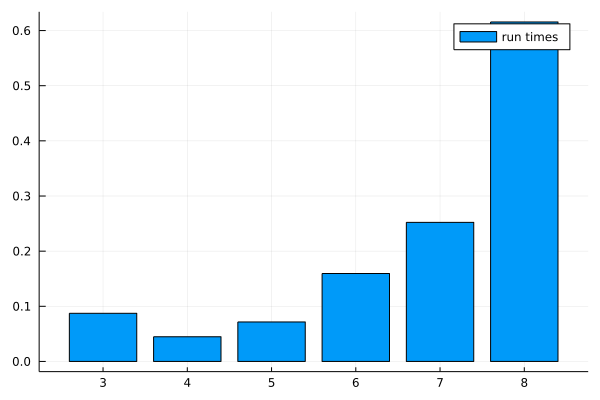

In [96]:
num_steps = [3, 4, 5, 6, 7, 8];
run_times = map(get_run_time, num_steps)
println("Runtime in ms for a given number of steps:")
StatsPlots.bar(num_steps,run_times, label = "run times")

Most of this computation is unnecessary. If the agent starts at `state === 0`, there are three ways the agent could be at `state === 0` again after two steps: either the agent stays put twice or the agent goes one step away and then returns. The code above computes `agent(0, totalTime-2)` three times, while it only needs to be computed once. This problem can be resolved by *memoization*, which stores the results of a function call for re-use when the function is called again on the same input. This use of memoization results in a runtime that is polynomial in the number of states and the total time. <!-- We explore the efficiency of these algorithms in more detail in Section VI. --> In WebPPL, we use the higher-order function `dp.cache` to memoize the `act` and `expectedUtility` functions:

~~~~javascript
///fold: transition, utility and makeAgent functions as above, but...
// ...with `act` and `expectedUtility` wrapped in `dp.cache`
var transition = function(state, action) {
  return state + action;
};

var utility = function(state) {
  if (state === 3) {
    return 1;
  } else {
    return 0;
  }
};

var makeAgent = function() { 
  var act = dp.cache(function(state, timeLeft) {
    return Infer({ model() {
      var action = uniformDraw([-1, 0, 1]);
      var eu = expectedUtility(state, action, timeLeft);
      factor(100 * eu);
      return action;
    }});
  });

  var expectedUtility = dp.cache(function(state, action, timeLeft) {
    var u = utility(state, action);
    var newTimeLeft = timeLeft - 1;
    if (newTimeLeft === 0) {
      return u; 
    } else {
      return u + expectation(Infer({ model() {
        var nextState = transition(state, action); 
        var nextAction = sample(act(nextState, newTimeLeft));
        return expectedUtility(nextState, nextAction, newTimeLeft);
      }}));
    }
  });

  return { act };
}


var act = makeAgent().act;

var simulate = function(state, timeLeft){
  if (timeLeft === 0){
    return [];
  } else {
    var action = sample(act(state, timeLeft));
    var nextState = transition(state, action); 
    return [state].concat(simulate(nextState, timeLeft - 1))
  }
};
///

var startState = 0;

var getRuntime = function(totalTime) {
  return timeit(function() {
    return act(startState, totalTime);
  }).runtimeInMilliseconds.toPrecision(4);
};

var numSteps = [3, 4, 5, 6, 7];
var runtimes = map(getRuntime, numSteps);

print('WITH MEMOIZATION \n');
print('Runtime in ms for for a given number of steps: \n')
print(_.zipObject(numSteps, runtimes));
viz.bar(numSteps, runtimes)
~~~~

In [70]:
function transition(state,action)
    return state+action
end

function utility(state)
  if state == 3
    return 1
  else
    return 0
  end
end

function make_agent()
    @memoize function expected_utility(state,action,time_left)
        u = utility(state)
        new_time_left = time_left-1
        if new_time_left == 0
            return u
        else
            eus = []
            next_state = transition(state,action)
            trace, = generate(act, (next_state,new_time_left), choicemap((:factor,1)))
            push!(eus,expected_utility(next_state, trace[:action], new_time_left))
            return u + mean(eus)
        end
    end
    
    @gen function act(state,time_left)
        action = @trace(uniform_discrete(-1,1),:action)
        eu = expected_utility(state,action,time_left)
        @trace(bernoulli(exp(100 * eu)),:factor)
    end
    return (act,expected_utility)
end

function simulate(start_state,total_time,steps_to_simulate)
    states = [start_state]
    act, = make_agent()
    amount_of_computation = 1000
    for i = 1:steps_to_simulate
        trace, = generate(act,(start_state,total_time), choicemap((:factor,1)))
        for i = 1:amount_of_computation
            trace, = Gen.mh(trace, select(:action))
        end
        next_state = transition(start_state,trace[:action])
        start_state = next_state
        total_time = total_time - 1
        push!(states,next_state)
    end
    return states
end

start_state = 0
function get_run_time(total_time)
    return @elapsed simulate(start_state,total_time,1)
end


get_run_time (generic function with 1 method)

Runtime in ms for a given number of steps:


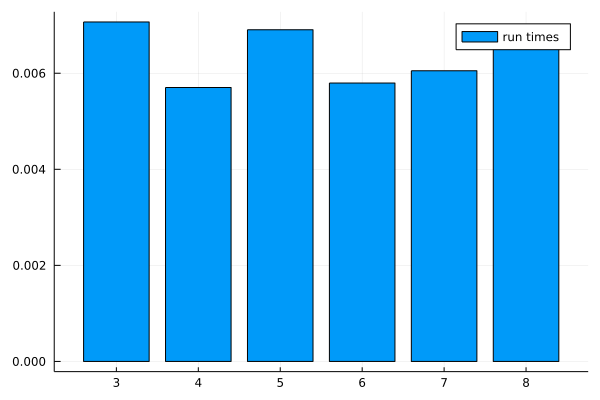

In [94]:
num_steps = [3, 4, 5, 6, 7, 8];
run_times = map(get_run_time, num_steps)
println("Runtime in ms for a given number of steps:")
StatsPlots.bar(num_steps,run_times, label = "run times")

>**Exercise**: Could we also memoize `simulate`? Why or why not?

<a id='restaurant_choice'></a>

## Choosing restaurants in Gridworld

The agent model above that includes memoization allows us to solve Bob's "Restaurant Choice" problem efficiently. 

We extend the agent model above by adding a `terminateAfterAction` to certain states to halt simulations when the agent reaches these states. For the Restaurant Choice problem, the restaurants are assumed to be terminal states. After computing the agent's trajectory, we use the [webppl-agents library](https://github.com/agentmodels/webppl-agents) to animate it.

~~~~javascript
///fold: Restaurant constants, tableToUtilityFunction

var ___ = ' '; 
var DN = { name : 'Donut N' };
var DS = { name : 'Donut S' };
var V = { name : 'Veg' };
var N = { name : 'Noodle' };

var tableToUtilityFunction = function(table, feature) {
  return function(state, action) {
    var stateFeatureName = feature(state).name;
    return stateFeatureName ? table[stateFeatureName] : table.timeCost;
  };
};
///

// Construct world

var grid = [
  ['#', '#', '#', '#',  V , '#'],
  ['#', '#', '#', ___, ___, ___],
  ['#', '#', DN , ___, '#', ___],
  ['#', '#', '#', ___, '#', ___],
  ['#', '#', '#', ___, ___, ___],
  ['#', '#', '#', ___, '#',  N ],
  [___, ___, ___, ___, '#', '#'],
  [DS , '#', '#', ___, '#', '#']
];

var mdp = makeGridWorldMDP({
  grid,
  start: [3, 1],
  totalTime: 9
});

var world = mdp.world;
var transition = world.transition;
var stateToActions = world.stateToActions;


// Construct utility function

var utilityTable = {
  'Donut S': 1, 
  'Donut N': 1, 
  'Veg': 3,
  'Noodle': 2, 
  'timeCost': -0.1
};

var utility = tableToUtilityFunction(utilityTable, world.feature);


// Construct agent

var makeAgent = function() {
  
  var act = dp.cache(function(state) {
    return Infer({ model() {
      var action = uniformDraw(stateToActions(state));
      var eu = expectedUtility(state, action);
      factor(100 * eu);
      return action;
    }});
  });

  var expectedUtility = dp.cache(function(state, action){
    var u = utility(state, action);
    if (state.terminateAfterAction){
      return u; 
    } else {
      return u + expectation(Infer({ model() {
        var nextState = transition(state, action);
        var nextAction = sample(act(nextState));
        return expectedUtility(nextState, nextAction);
      }}));
    }
  });
  
  return { act };
};

var act = makeAgent().act;


// Generate and draw a trajectory

var simulate = function(state) {
  var action = sample(act(state));
  var nextState = transition(state, action);
  var out = [state, action];
  if (state.terminateAfterAction) {
    return [out];
  } else {
    return [out].concat(simulate(nextState));
  }
};

var trajectory = simulate(mdp.startState);

viz.gridworld(world, { trajectory: map(first, trajectory) });
~~~~

In [ ]:
#TODO: write above code in julia and gen

>**Exercise**: Change the utility table such that the agent goes to `Donut S`. What ways are there to accomplish this outcome?

### Noisy agents, stochastic environments

This section looked at two MDPs that were essentially deterministic. Part of the difficulty of solving MDPs is that actions, rewards and transitions can be stochastic. The [next chapter](/chapters/3b-mdp-gridworld.html) explores both noisy agents and stochastic gridworld environments.
